<a href="https://colab.research.google.com/github/MominAhmedShaikh/CNN-Multiclass-classification-BarkVNet-50/blob/main/Bark_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Pre-requisites and importing libraries

### Downloading Dataset from kaggle

In [1]:
! pip install kaggle -q
! pip install split-folders -q
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d saurabhshahane/barkvn50

 94% 165M/176M [00:01<00:00, 97.3MB/s]
100% 176M/176M [00:01<00:00, 116MB/s] 


### Importing libraries

In [2]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras import regularizers
from keras import layers,models
from zipfile import ZipFile
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
import splitfolders
import numpy as np
import pandas as pd
import os
import random
import cv2

### Extracting Zip File downloaded from Kaggle

In [3]:
file_name = "/content/barkvn50.zip"
  
with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Extracted All Files...')


Extracted All Files...


### Creating new directory to Store images 

In [4]:
os.mkdir('/content/BarkVN50 splits')

### Splitiing the dataset into train, test and validation

In [5]:
input = '/content/BarkVN-50/BarkVN-50_mendeley'
output = '/content/BarkVN50 splits'
splitfolders.ratio(input = input ,output = output,seed = 1,ratio = (0.85,0.10,0.05))
os.listdir('/content/BarkVN50 splits')

Copying files: 5578 files [00:01, 4540.64 files/s]


['train', 'test', 'val']

# Loading data and image Preprocessing

#### 1 . Splitting folder names
#### 2 . Storing class names in variable class labels

In [6]:
split_names = []
class_labels = []
for i,j,k in os.walk('/content/BarkVN50 splits/train'):
  split_names.append(i.split('/',maxsplit=4))
for i in range(1,len(split_names),1):
  class_labels.append(split_names[i][4])
class_labels.sort()

#### 1 . Generating training and testing data
- Here, we can use function from keras utils (flow from directory) but for deeper understanding images and its labels we have used this custom function.
- We have not shuffled the training and testing data.
- Splitting the data into train and then splitting it into train_images and its train_labels variables.

In [7]:
IMG_SIZE = 200

DATADIR = '/content/BarkVN50 splits/train'


training_data = []

def create_training_data():
    for category in class_labels :
        path = os.path.join(DATADIR, category)
        class_num = class_labels.index(category)
        for img in os.listdir(path):
            try :
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_UNCHANGED)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()


train_images = [] #features
train_labels = [] #labels

for features, label in training_data:
    train_images.append(features)
    train_labels.append(label)

train_images = np.array(train_images).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
train_labels = np.asarray(train_labels)

- Splitting the data into test and then splitting it into test_images and its test_labels variables.

In [8]:
IMG_SIZE = 200

DATADIR = '/content/BarkVN50 splits/test'


testing_data = []

def create_training_data():
    for category in class_labels :
        path = os.path.join(DATADIR, category)
        class_num = class_labels.index(category)
        for img in os.listdir(path):
            try :
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_UNCHANGED)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                testing_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()


test_images = [] #features
test_labels = [] #labels

for features, label in testing_data:
    test_images.append(features)
    test_labels.append(label)

test_images = np.array(test_images).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
test_labels = np.asarray(test_labels)

In [9]:
len(training_data),len(testing_data)

(4720, 319)

#### Normalizing tensors between 0 and 255
- Normalizing will make sure that pixels are distributed evenly.
- Other methods includes dividing directly by 255, but it consumes all memory and forces system to crash.

In [10]:
train_images = tf.cast(train_images/255. ,tf.float32)
test_images = tf.cast(test_images/255. ,tf.float32)

#### Visualizing Images 
- One image from training data and one image for testing data to make sure everything is working fine.

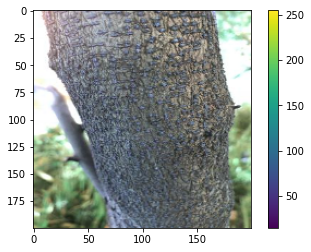

In [11]:
plt.figure()
plt.imshow(training_data[0][0])
plt.colorbar()
plt.grid(False)
plt.show()

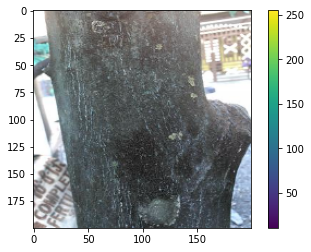

In [12]:
plt.figure()
plt.imshow(testing_data[99][0]) 
plt.colorbar()
plt.grid(False)
plt.show()

- Displaying first 25 images of training dataset which contains images of Acacia (As we have not shuffled the data)

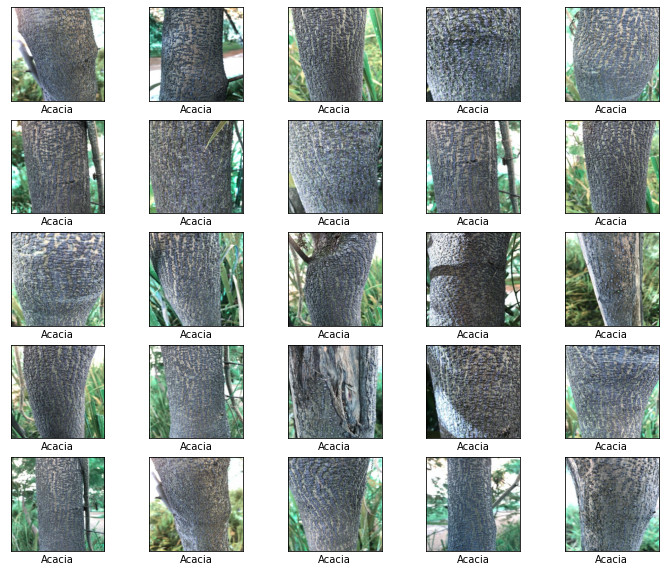

In [13]:
plt.figure(figsize=(12,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_labels[training_data[i][1]])
plt.show()

# Defining Functions

In [14]:
def plot(model,model_history,title):
    '''
    Plot loss and accuracy of given model

    Parameters:

    model = After Adding layers inside model, pass that model here!
    model_history = Add model history object
    title = title you want to set
    metric = Look for metric (eg . val_loss,val_accuracy,etc)

    '''
    df = pd.DataFrame(model_history.history)
    plt.figure(figsize=(20, 5))
    plt.suptitle(title,fontsize = 20)
    plt.subplot(1, 2, 1)
    
    plt.plot(df['accuracy'],color = 'blue')
    plt.plot(df['val_accuracy'],color = 'red')
    plt.xlabel('# of epochs')
    plt.ylabel('acc metrics')
    plt.legend(['train_accuracy','test_accuracy'])
    
    plt.subplot(1, 2, 2)
    
    plt.plot(df['loss'],color = 'blue')
    plt.plot(df['val_loss'],color = 'red')
    plt.xlabel('# of epochs')
    plt.ylabel('loss metrics')
    plt.legend(['train_loss','test_loss'])
    plt.show()

    
    results = model.evaluate(test_images, test_labels)
    return results

In [15]:
def model_training_CNN(model,epochs = 20):

  '''
    Parameters:

    model = Takes input of layered model
    epochs = default 20 (As early stopping is used)

    Output:
    returns history object later can be fetch for losses and accuracies.

    '''

  model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
  
  history = model.fit(train_images
                       , train_labels
                       , epochs=epochs
                       , validation_data=(test_images, test_labels)
                       , verbose=0
                       , callbacks = tf.keras.callbacks.EarlyStopping(monitor='accuracy',patience=3)
        )
  print(model.evaluate(test_images,test_labels))

  return history

In [16]:
def report(model,cls = False):

  '''
  Parameters:

    model = Takes input of layered model
    cls = Displayes Confusion matrix (default = False) (As it takes lot of memory usage)

    Output:
    returns classification report and displays confusion matrix


  '''

  y_pred=model.predict(test_images)
  y_pred=np.argmax(y_pred,axis=1)
  print(classification_report(y_pred,test_labels,zero_division=0))

  if cls == True:
    z = pd.crosstab(y_pred,test_labels)
    fig = px.imshow(z, text_auto=True,aspect="auto")
    fig.update_layout(
    width = 1700, height = 1000,
    autosize = True )
    fig.show()

In [17]:
def plot_image(i, predictions_array, true_label, img):
  '''
  Parameters:

    i = Label of testing or validation data want to display.

    predictions_array = Generates predictions based on (i) and softmax function.

    true_label = Actual label in testing set.
    
    img = Display img of label (i)

    Output:
    returns image with actual and predicted label

  '''


  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_labels[predicted_label],
                                100*np.max(predictions_array),
                                class_labels[true_label]),
                                color=color)

In [18]:
def plot_value_array(i, predictions_array, true_label):
  '''
  Parameters:

    i = Label of testing or validation data want to display.

    predictions_array = Generates predictions based on (i) and softmax function.
    
    true_label = Actual label in testing set.

    Output:
    returns barplot with actual and predicted label. If prediction is correct returns blue colored bar, else returns red color bar.

  '''
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(50))
  plt.yticks([])
  thisplot = plt.bar(range(50), predictions_array, color="#f3f2f2")
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# Model building

- Optimizer - Adam
- loss - SparseCategoricalCrossentropy
- metric measured - Accuracy
- Activation function between layers - ReLU
- Activation function in last layers - Softmax
- Callback - Early stopping

### Base model

#### Baseline model was selected based on Arbirary Filters.
- 3 Convolution (16,8,4) Filters respectively and 3 Max Pooling layers selected with 'valid' padding and 3 Dense layers

In [19]:
base_model = models.Sequential()

base_model.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=(200, 200, 3),padding='valid'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(8, (2, 2), activation='relu',padding='valid'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(4, (2, 2), activation='relu',padding='valid'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Flatten())

base_model.add(layers.Dense(32, activation='relu'))
base_model.add(layers.Dense(16, activation='relu'))

base_model.add(layers.Dense(50,activation = 'softmax'))

In [20]:
base_model_history = model_training_CNN(base_model)

KeyboardInterrupt: ignored

In [ ]:
plot(base_model,base_model_history,'Base Model')

In [ ]:
report(base_model)

### Neurons increased model (Neuro-Mod)

In [ ]:
neuro_model = models.Sequential()
neuro_model.add(layers.Conv2D(64, (2, 2), activation='relu', input_shape=(200, 200, 3),padding='valid'))
neuro_model.add(layers.MaxPooling2D((2, 2)))
neuro_model.add(layers.Conv2D(32, (2, 2), activation='relu',padding='valid'))
neuro_model.add(layers.MaxPooling2D((2, 2)))
neuro_model.add(layers.Conv2D(16, (2, 2), activation='relu',padding='valid'))
neuro_model.add(layers.MaxPooling2D((2, 2)))
neuro_model.add(layers.Flatten())
neuro_model.add(layers.Dense(32, activation='relu'))
neuro_model.add(layers.Dense(16, activation='relu'))
neuro_model.add(layers.Dense(50,activation = 'softmax'))

In [ ]:
neuro_model_history = model_training_CNN(neuro_model)

In [ ]:
plot(neuro_model,neuro_model_history,'Neuro Model')

In [ ]:
report(neuro_model)

### Regularized Model

In [ ]:
reg_model = models.Sequential()
reg_model.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=(200, 200, 3),padding='valid',kernel_regularizer=regularizers.l2(0.001)))
reg_model.add(layers.MaxPooling2D((2, 2)))

reg_model.add(layers.Conv2D(8, (2, 2), activation='relu',padding='valid',kernel_regularizer=regularizers.l2(0.001)))
reg_model.add(layers.MaxPooling2D((2, 2)))

reg_model.add(layers.Conv2D(4, (2, 2), activation='relu',padding='valid',kernel_regularizer=regularizers.l2(0.001)))
reg_model.add(layers.MaxPooling2D((2, 2)))

reg_model.add(layers.Flatten())

reg_model.add(layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
reg_model.add(layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.001)))

reg_model.add(layers.Dense(50,activation = 'softmax'))


In [ ]:
reg_model_history = model_training_CNN(reg_model)

In [ ]:
plot(reg_model,reg_model_history,'L2 Regularized Model')

In [ ]:
report(reg_model)

### Dropout Model

In [ ]:
drop_model = models.Sequential()

drop_model.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=(200, 200, 3),padding='valid'))
drop_model.add(layers.MaxPooling2D((2, 2)))

drop_model.add(layers.Conv2D(8, (2, 2), activation='relu',padding='valid'))
drop_model.add(layers.MaxPooling2D((2, 2)))

drop_model.add(layers.Conv2D(4, (2, 2), activation='relu',padding='valid'))
drop_model.add(layers.MaxPooling2D((2, 2)))

drop_model.add(layers.Flatten())

drop_model.add(layers.Dense(32, activation='relu'))
drop_model.add(layers.Dropout(0.1))
drop_model.add(layers.Dense(16, activation='relu'))
drop_model.add(layers.Dropout(0.1))
drop_model.add(layers.Dense(50,activation = 'softmax'))


In [ ]:
drop_model_history = model_training_CNN(drop_model)

In [ ]:
plot(drop_model,drop_model_history,'Dropout Layer Model')

In [ ]:
report(drop_model)

### Combine Model

In [ ]:
combine_model = models.Sequential()
combine_model.add(layers.Conv2D(64, (2, 2), activation='relu', input_shape=(200, 200, 3),padding='valid',kernel_regularizer=regularizers.l2(0.001)))
combine_model.add(layers.MaxPooling2D((2, 2)))

combine_model.add(layers.Conv2D(32, (2, 2), activation='relu',padding='valid',kernel_regularizer=regularizers.l2(0.001)))
combine_model.add(layers.MaxPooling2D((2, 2)))

combine_model.add(layers.Conv2D(16, (2, 2), activation='relu',padding='valid',kernel_regularizer=regularizers.l2(0.001)))
combine_model.add(layers.MaxPooling2D((2, 2)))

combine_model.add(layers.Flatten())

combine_model.add(layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
combine_model.add(layers.Dropout(0.1))
combine_model.add(layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
combine_model.add(layers.Dropout(0.1))
combine_model.add(layers.Dense(50,activation = 'softmax'))

In [ ]:
combine_model_history = model_training_CNN(combine_model)

In [ ]:
plot(combine_model,combine_model_history,'Combine Model')

In [ ]:
report(combine_model)